In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework.ops import disable_eager_execution
from scipy.stats import rankdata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import graphviz

import random


In [2]:
from sklearn.impute import SimpleImputer


disable_eager_execution()

data = pd.read_csv('dataset2.csv', sep=';', skipinitialspace=True)

# convertir columnas a numericas
data['Res_max_comp_kpsi'] = pd.to_numeric(data['Res_max_comp_kpsi'], errors='coerce')
data['Res_max_comp_Mpa'] = pd.to_numeric(data['Res_max_comp_Mpa'], errors='coerce')

# columnas no numericas son eliminadas del dataframe numerico
columnas_nonum = data.select_dtypes(exclude=['number']).columns
num_data = data.drop(columns=columnas_nonum)

#tratamiento valores nulos en los datos numericos
imputer = SimpleImputer(strategy='mean')  
num_data_imputed = imputer.fit_transform(num_data)

# escalado los datos
scaler = StandardScaler()
scaled_data_imputed = scaler.fit_transform(num_data_imputed)

print(scaled_data_imputed)


[[-3.78322330e-01 -3.77317278e-01 -1.77453113e-01 -1.76660016e-01
  -5.29149723e-01 -5.29214353e-01 -1.89181061e+00]
 [-3.36354516e-01 -3.36754780e-01  7.23907255e-01  7.21692675e-01
  -4.75854776e-01 -4.75902829e-01 -1.89181061e+00]
 [-3.50343787e-01 -3.50951655e-01  4.53499145e-01  4.53820236e-01
  -3.15969936e-01 -3.15968257e-01 -1.89181061e+00]
 [-2.80397431e-01 -2.79967283e-01  7.23907255e-01  7.21692675e-01
  -3.15969936e-01 -3.15968257e-01 -1.89181061e+00]
 [-3.64333059e-01 -3.63120404e-01  7.23907255e-01  7.21692675e-01
  -3.95912356e-01 -3.95935543e-01 -1.89181061e+00]
 [-3.92311601e-01 -3.91514152e-01 -4.02793206e-01 -4.02064873e-01
  -6.35739616e-01 -6.35451086e-01 -1.89181061e+00]
 [-3.92311601e-01 -3.91514152e-01  7.23907255e-01  7.21692675e-01
  -5.29149723e-01 -5.29214353e-01 -1.89181061e+00]
 [-3.92311601e-01 -3.93542277e-01  2.73227071e-01  2.74149698e-01
  -5.82444670e-01 -5.82139562e-01 -1.89181061e+00]
 [-3.64333059e-01 -3.69204779e-01  1.35485951e+00  1.35543966e+0

In [3]:
dim_data = scaled_data_imputed.shape[1]
dim_mid = 12
dim_fin = 64
epochs = 500
batch_size = 32



In [4]:
#se construye el codificador modificado, dado que este funcionara con datos tabulares
inputs = Input(shape=(dim_data,))
h = Dense(dim_fin, activation='relu')(inputs)
h = BatchNormalization()(h)
z_mean = Dense(dim_mid)(h)
z_log_var = Dense(dim_mid)(h)



Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# funcion de muestreo
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon # media + varianza * distribucion normal (reparameterization trick)

z = Lambda(sampling)([z_mean, z_log_var])



In [6]:
# decodificador
deco = Dense(dim_fin, activation='relu')
deco_mean = Dense(dim_data, activation='sigmoid')
decoded = deco(z)
outputs = deco_mean(decoded)


vae = Model(inputs, outputs)




In [7]:
def vae_loss(x, x_decoded_mean):
    xent_loss = dim_data * tf.keras.losses.mean_squared_error(x, x_decoded_mean)  # Perdida de reconstruccion para distribucion normal
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  # perdida de divergencia KL
    return K.mean(xent_loss + kl_loss)



In [8]:
vae.compile(optimizer='adam', loss=vae_loss)

# training
vae.fit(scaled_data_imputed, scaled_data_imputed,
        epochs=epochs,
        batch_size=batch_size)




Train on 87 samples
Epoch 1/500
87/87 [==============================] - 1s 12ms/sample - loss: 48.6127
Epoch 2/500
87/87 [==============================] - 0s 303us/sample - loss: 67.0945
Epoch 3/500
87/87 [==============================] - 0s 232us/sample - loss: 55.4365
Epoch 4/500
87/87 [==============================] - 0s 345us/sample - loss: 34.4175
Epoch 5/500
87/87 [==============================] - 0s 186us/sample - loss: 22.0121
Epoch 6/500
87/87 [==============================] - 0s 197us/sample - loss: 22.5744
Epoch 7/500
87/87 [==============================] - 0s 198us/sample - loss: 20.4199
Epoch 8/500
87/87 [==============================] - 0s 212us/sample - loss: 17.9739
Epoch 9/500
87/87 [==============================] - 0s 160us/sample - loss: 15.6880
Epoch 10/500
87/87 [==============================] - 0s 172us/sample - loss: 14.0935
Epoch 11/500
87/87 [==============================] - 0s 242us/sample - loss: 14.2958
Epoch 12/500
87/87 [========================

In [9]:

#se define el numero de samples que se necesitan y se genera un espacio latente
samp =4800
dim_mid = vae.input_shape[1]
random_val = np.random.normal(size=(samp, dim_mid))

# se generan los datos sinteticos
y_pred = vae.predict(random_val)
data_sintetica = scaler.inverse_transform(y_pred)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [10]:
# CSV
df_datasint = pd.DataFrame(data_sintetica, columns=num_data.columns)
df_datasint.to_csv('data_sintetica.csv', index=False)
df_datasint['Tipo'] = df_datasint['Tipo'].round()

data = pd.read_csv('dataset2.csv', sep=';', skipinitialspace=True)

numeric_data=data.drop("Material",axis=1)
for col in data.columns:
     data[col] = pd.to_numeric(data[col], errors='coerce')
col= numeric_data.columns.intersection(df_datasint.columns)
df_final = pd.concat([numeric_data[col], df_datasint[col]], axis=0)
df_final.to_csv('data_final.csv', index=False)
print(df_final.head())

   mod_elasticidad_aproximado_Mpsi  mod_elasticidad_aproximado_Gpa  \
0                              0.3                             2.1   
1                              0.6                             4.1   
2                              0.5                             3.4   
3                              1.0                             6.9   
4                              0.4                             2.8   

   Res_max_tension_kpsi  Res_max_tension_Mpa Res_max_comp_kpsi  \
0                   6.0                 41.4              10.0   
1                  10.0                 68.9              12.0   
2                   8.8                 60.7              18.0   
3                  10.0                 68.9              18.0   
4                  10.0                 68.9              15.0   

  Res_max_comp_Mpa  Tipo  
0             68.9   0.0  
1             82.7   0.0  
2            124.1   0.0  
3            124.1   0.0  
4            103.4   0.0  


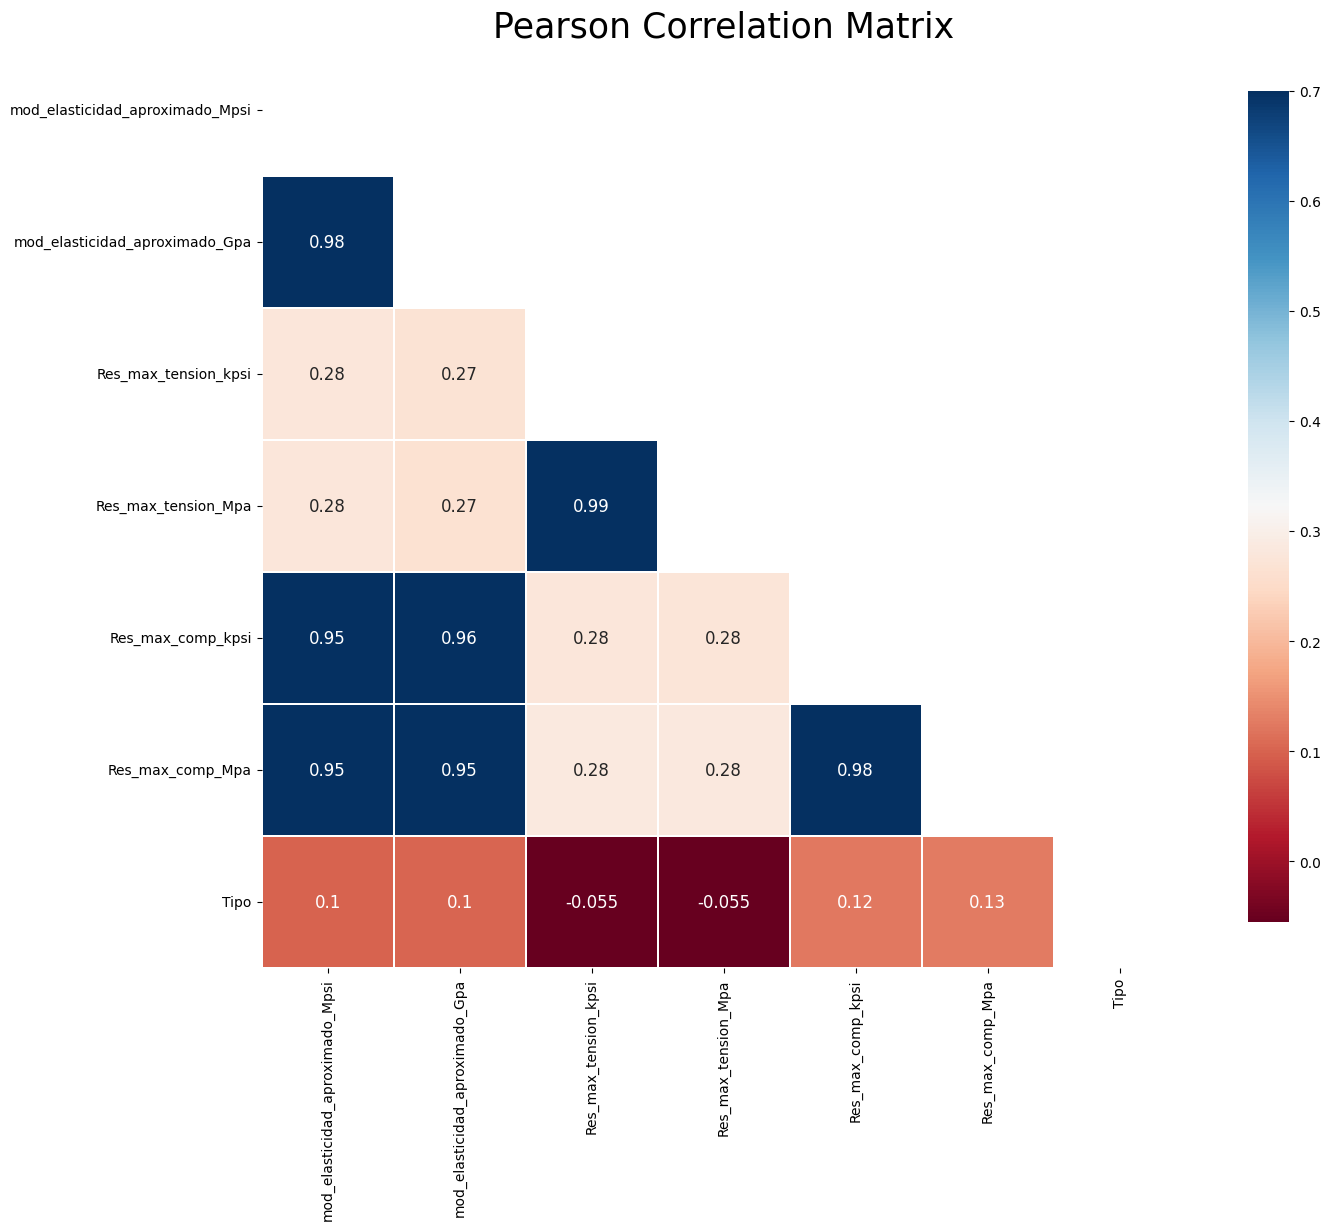

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('data_final.csv')

for col in data.columns:
     data[col] = pd.to_numeric(data[col], errors='coerce')
numerical_data = data.select_dtypes(include=[np.number])

mask = np.zeros_like(numerical_data.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(numerical_data.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="RdBu",
            linecolor='w',annot=True,annot_kws={"size":12},mask=mask,cbar_kws={"shrink": .9});

In [12]:
data = pd.read_csv('data_final.csv')
colum = ['Material']

encoder = OneHotEncoder(sparse=False, drop='first')

preprocessor = ColumnTransformer(
    transformers=[('cat', encoder, colum)],
    remainder='passthrough'
)

encoded = preprocessor.fit_transform(data)
encoded_df = pd.DataFrame(encoded, columns=preprocessor.get_feature_names_out())

# concatena el dataframe original con el datframe de columnas codificadas
data_encoded = pd.concat([data, encoded_df], axis=1)
print(len(data_encoded))

ValueError: A given column is not a column of the dataframe

In [12]:
data = pd.read_csv('data_final.csv')
target_columns = ['mod_elasticidad_aproximado_Mpsi', 'mod_elasticidad_aproximado_Gpa']
X = data.drop(columns=target_columns).values
y = data[target_columns].values #variables objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.isnan(y_test).sum())

0


In [13]:
X_train_numeric = np.where(X_train == '-', np.nan, X_train)
X_train_numeric = X_train_numeric.astype(np.float64)

mask = ~np.isnan(X_train_numeric).any(axis=1)
X_train_numeric = X_train_numeric[mask]
y_train = y_train[mask]
print(np.isnan(X_train_numeric).sum())

0


In [14]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean') #rellenar valores faltantes en caso de existir con el promedio
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [15]:
model = MLPRegressor(hidden_layer_sizes=(100), activation='relu', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=100, max_iter=1000, random_state=42)

In [16]:
y_pred = model.predict(X_test_scaled)

In [17]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.2f}')
print(f'R2: {r2:.2f}')

MSE: 9.91
R2: 0.93


In [18]:
print(y_pred)
column_names = ['mod_elasticidad_aproximado_Mpsi','Res_max_tension_Mpa']
y_pred_df = pd.DataFrame(data=y_pred, columns=column_names)

# Guardar el dataframe en un archivo CSV
y_pred_df.to_csv('resultados_prediccion.csv', index=False)

[[ 3.0806434  21.1274842 ]
 [ 6.84644604 45.81904355]
 [ 3.03758146 20.74604898]
 ...
 [ 3.00976482 20.6741452 ]
 [ 3.03858529 20.75291416]
 [ 3.03859589 20.75280309]]


In [ ]:
hidden_layer_configurations = [
    (10),(10,10),(20),(30),(40), (50), (60), (64,32) , (100,), (200,), (300,),
    (100, 50), (200, 100), (300, 150),
    (100, 50, 25), (200, 100, 50), (300, 150, 75), (350,100), (400,100),(500,100),(1000),(1500),(2000), (3000)
]

results = []

for config in hidden_layer_configurations:

    model = MLPRegressor(hidden_layer_sizes=config, activation='relu', max_iter=2000, random_state=42)


    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'hidden_layers': config,
        'MSE': mse,
        'R2': r2
    })

results_df = pd.DataFrame(results)
results_df.to_csv('results_vae.csv', sep=',', index=False)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce